# Comparison of Briere and flexTPC models in insect development data

In [2]:
import numpy as np
import pandas as pd
import random
random.seed(42) # Set seed for reproducibility

from matplotlib import pyplot as plt

from scipy.optimize import minimize
from sklearn.model_selection import LeaveOneOut

In [3]:
def briere1(T, Tmin=10.0, Tmax=50.0, c=1.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) + 0.5 * np.log(Tmax - T[cond]))
    return result

def briere2(T, Tmin=10.0, Tmax=50.0, c=1.0, b=2.0):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    result[cond] = c * T[cond] * np.exp(np.log(T[cond] - Tmin) +  np.log(Tmax - T[cond]) / b)
    return result

# Fully biologically interpretable parametrization of flexTPC model
def flexTPC(T, Tmin=10.0, Tmax=50.0, rmax=1.0, α=0.8, β=0.2):
    result = np.zeros(len(T))
    cond = (Tmin < T) & (T < Tmax)
    s = α * (1.0 - α) / β**2
    result[cond] = rmax * np.exp(s * (α * (np.log(T[cond] - Tmin) - np.log(α)) +
                                      (1 - α) * (np.log(Tmax - T[cond]) - np.log(1 - α) )
                                       - np.log(Tmax - Tmin)))
    return result

In [4]:
def nloglik(θ, Tdata, rdata, model=flexTPC):
    params, σ2 = θ[:-1], θ[-1]
    Tmin, Tmax = θ[:2]
    outside = (Tdata < Tmin) | (Tdata > Tmax)
    inside = ~outside
    n = len(rdata[inside])
    if np.any(rdata[outside] > 0.0):
        return np.inf
    else:
        return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
    
def AIC(nll, p):
    return 2 * nll + 2 * p 

def BIC(nll, n, p):
    return 2 * nll + p * np.log(n)

## L. botrana development dataset

First, let's compare the model performance in Briere's original dataset.

In [5]:
botrana = pd.read_csv("briere_data_L_botrana.csv")
stages = ["eggs", "i1", "i2", "i3", "i4", "i5", "pupae"]

In [6]:
botrana

,T,n_eggs,eggs,n_i1,i1,n_i2,i2,n_i3,i3,n_i4,i4,n_i5,i5,n_pupae,pupae
0,8,0,inf,0,inf,0,inf,0,inf,0,inf,0,inf,0,inf
1,10,0,inf,28,25.9,14,23.2,0,inf,0,inf,0,inf,0,inf
2,12,77,26.8,48,23.4,23,16.1,15,12.7,12,15.7,11,25.5,0,inf
3,14,104,19.4,45,15.1,36,10.6,32,9.8,31,10.6,31,17.9,6,48.0
4,16,369,15.6,47,13.2,41,8.9,36,8.3,35,10.0,33,13.5,25,35.5
5,18,600,11.0,44,11.7,41,7.1,40,5.6,38,7.0,36,13.3,41,23.2
6,20,674,8.2,44,5.9,44,4.8,40,4.7,37,5.1,35,7.6,41,15.1
7,22,837,7.0,50,4.2,48,3.8,46,4.0,42,4.9,41,7.1,45,12.9
8,24,662,5.3,49,3.9,45,3.1,44,3.8,44,3.7,40,6.5,50,10.2
9,26,696,5.1,50,3.7,45,3.0,45,3.2,44,3.6,40,6.2,50,8.6


In [7]:
# Find initial estimates of minimum and maximum temperatures from data.
Tlims = {}
for i, stage in enumerate(stages):
    T = botrana["T"][botrana[stage] < np.inf]
    Tlims[stage] = (min(T) - 0.5, max(T) + 0.5)
    print(stage, Tlims[stage])

# Set initial estimates of maximum trait value.
init_rmax = {'eggs': 0.2,
             'i1':0.2,
             'i2':0.2,
             'i3':0.2,
             'i4':0.2,
             'i5':0.2,
            'pupae':0.2}

# Set initial parameter values for all models.
initial_flex = {stage:[7.0, 36.0, init_rmax[stage], 0.8, 0.1, 0.015] for stage in stages}
initial_b1 = {stage:[7.0, 36.0, 7e-5, 0.015] for stage in stages}
initial_b2 = {stage:[7.0, 36.0, 7e-5, 2.0, 0.015] for stage in stages}

eggs (11.5, 30.5)
i1 (9.5, 34.5)
i2 (9.5, 34.5)
i3 (11.5, 32.5)
i4 (11.5, 32.5)
i5 (11.5, 32.5)
pupae (13.5, 32.5)


In [8]:
loo = LeaveOneOut()
loo.get_n_splits(botrana["T"])

14

In [9]:
# Calculate leave-one-out cross validated log likelihood.
params = {"flexTPC":{}, "b1":{}, "b2":{}}
models = ["b1", "b2", "flexTPC"]
method = "Nelder-Mead"
loocv_nll = {model:{stage:[] for stage in stages } for model in models}

for i, y in enumerate(stages):
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])
    
    for train, test in loo.split(Tdata):
        T_train, r_train = Tdata[train], rdata[train]
        T_test, r_test = Tdata[test], rdata[test]
        
        params["b1"][y] = minimize(nloglik, initial_b1[y],
                            bounds=[(0.0, 20.0), 
                                    (20.0, 60.0), 
                                    (0.0, 1.0),  
                                    (0, 1.0)],
                      args=(T_train, r_train, briere1), options={"maxiter":100000}, method=method)
        θ = params["b1"][y]["x"]
        loocv_nll["b1"][y].append(nloglik(θ, T_test, r_test, model=briere1))
        
        params["b2"][y] = minimize(nloglik, initial_b2[y],
                            bounds=[(0.0, 20.0), 
                                    (20.0, 60.0), 
                                    (0.0, 1.0), 
                                    (1.0, 20.0),
                                    (0, 1.0)],
                      args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
        θ = params["b2"][y]["x"]
        loocv_nll["b2"][y].append(nloglik(θ, T_test, r_test, model=briere2))
        
        params["flexTPC"][y] = minimize(nloglik, initial_flex[y],
                                bounds=[(0.0, 20.0), 
                                        (20.0, 60.0), 
                                        (0.0, 1.0), 
                                        (0.0, 1.0), 
                                        (0.0, np.inf), 
                                        (0, 1.0)],
                          args=(Tdata, rdata, flexTPC), options={"maxiter":100000}, method=method)
        θ = params["flexTPC"][y]["x"]
        loocv_nll["flexTPC"][y].append(nloglik(θ, T_test, r_test, model=flexTPC))

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_8663/2868019315.py:10: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_8663/2868019315.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_8663/2868019315.py:10: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))


In [10]:
# Fit to entire dataset.

params = {"flexTPC":{}, "b1":{}, "b2":{}}
models = ["b1", "b2", "flexTPC"]
method = "Nelder-Mead"

for i, y in enumerate(stages):
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])
    
    
    params["b1"][y] = minimize(nloglik, initial_b1[y],
                        bounds=[(0.0, 20.0), 
                                (20.0, 60.0), 
                                (0.0, 1.0),  
                                (0, 1.0)],
                  args=(Tdata, rdata, briere1), options={"maxiter":100000}, method=method)
    params["b2"][y] = minimize(nloglik, initial_b2[y],
                        bounds=[(0.0, 20.0), 
                                (20.0, 60.0), 
                                (0.0, 1.0), 
                                (1.0, 20.0),
                                (0, 1.0)],
                  args=(Tdata, rdata, briere2), options={"maxiter":100000}, method=method)
    params["flexTPC"][y] = minimize(nloglik, initial_flex[y],
                        bounds=[(0.0, 20.0), 
                                (20.0, 60.0), 
                                (0.0, 1.0), 
                                (0.0, 1.0), 
                                (0.0, np.inf), 
                                (0, 1.0)],
                  args=(Tdata, rdata, flexTPC), options={"maxiter":100000}, method=method)

/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_8663/2868019315.py:10: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_8663/2868019315.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))
/var/folders/g8/wjqhnz1n01d5l4pdv8cnykw40000gp/T/ipykernel_8663/2868019315.py:10: RuntimeWarning: invalid value encountered in scalar add
  return 0.5 * (n * np.log(2*np.pi*σ2) + np.sum((rdata[inside] - model(Tdata[inside], *params))**2 / σ2))


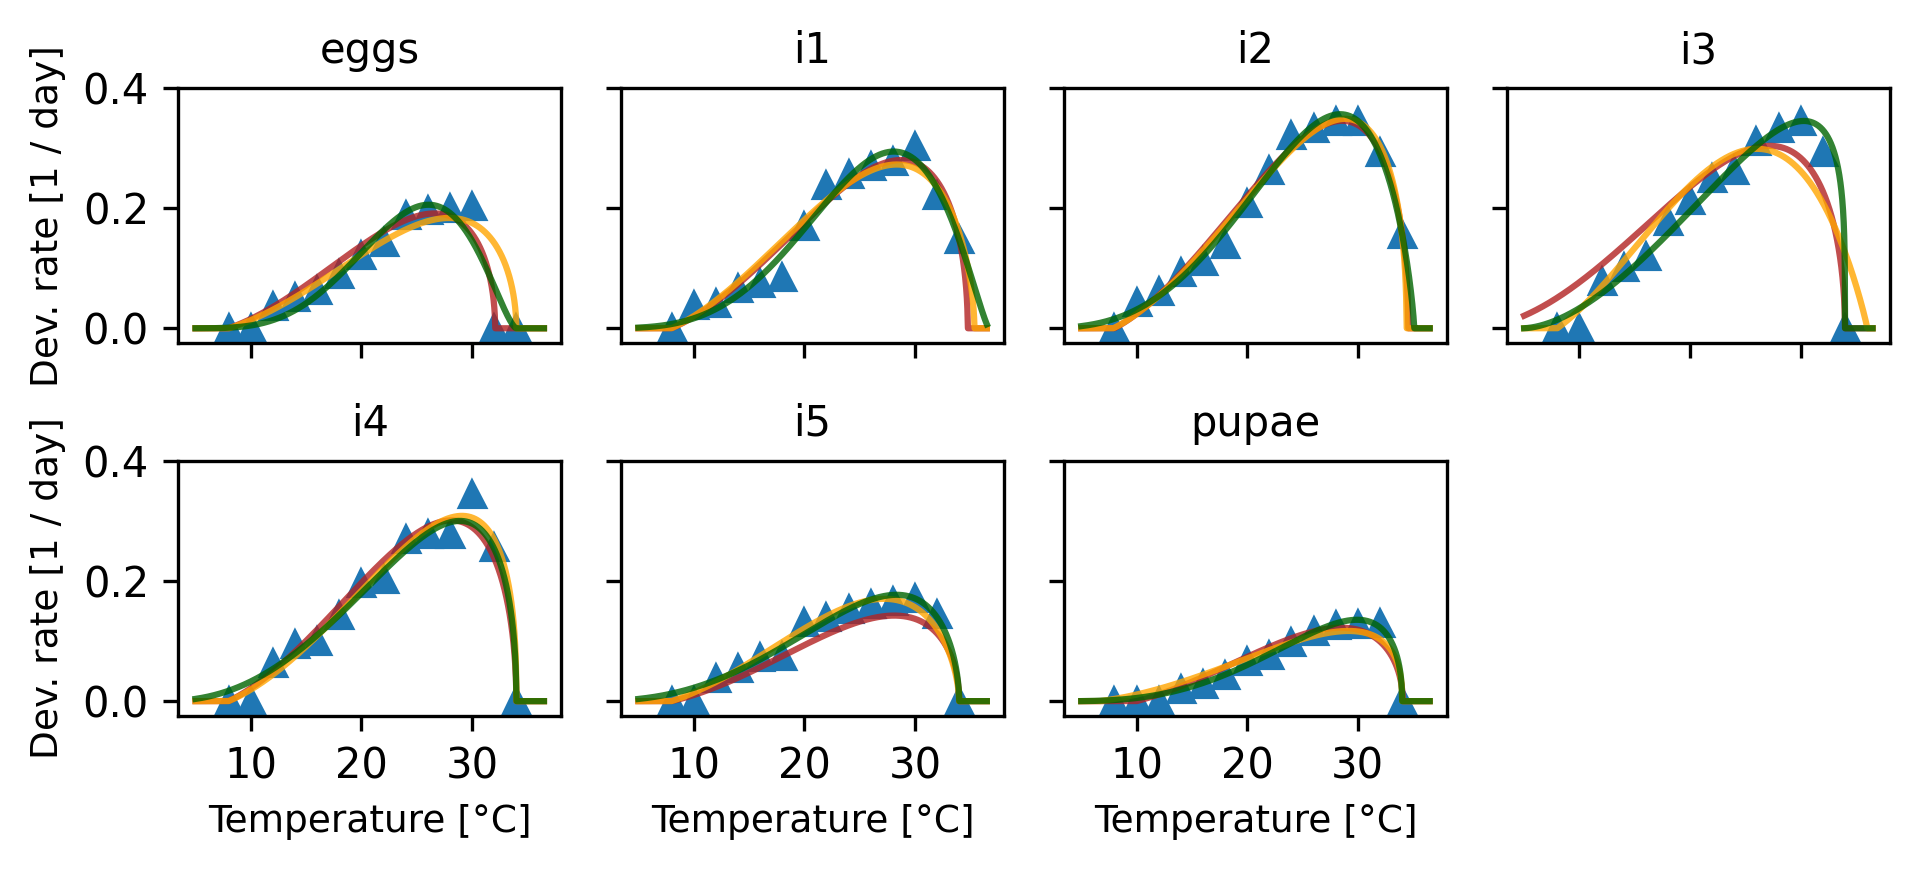

In [25]:
T = np.arange(5, 36.5, 0.001)
#plt.figure(figsize=(5, 6.5), dpi=300)
#plt.figure(figsize=(4.33, 6.5), dpi=300)
alpha=0.8

fig, axarr = plt.subplots(2, 4, figsize=(6.5, 3), dpi=300, sharex=True, sharey=True)

for i, y in enumerate(stages):
    ax = axarr[i // 4, i % 4]
    Tdata = np.array(botrana["T"])
    rdata = 1.0 / np.array(botrana[y])

    ax.plot(Tdata, rdata, '^')
    
    # Plot fitted curves by models.
    par = params["b1"][y]["x"]
    ax.plot(T, briere1(T, *par[:-1]), color="firebrick", alpha=alpha)
             
    par = params["b2"][y]["x"]
    ax.plot(T, briere2(T, *par[:-1]), color="orange", alpha=alpha)
    
    par = params["flexTPC"][y]["x"]
    ax.plot(T, flexTPC(T, *par[:-1]), color="darkgreen", alpha=alpha)
    ax.set_ylim(-0.025, 0.4)
    if y in ("eggs", "i4"):
        ax.set_ylabel("Dev. rate [1 / day]", fontsize=9)
    if y in ("i4", "i5", "pupae"):
        ax.set_xlabel("Temperature [°C]", fontsize=9)
    ax.set_title(y, fontsize=10)
axarr[-1, -1].axis("off")
plt.tight_layout()
plt.savefig("botrana.svg")
plt.savefig("botrana.tiff")
plt.savefig("botrana.png")
plt.savefig("botrana.pdf")

In [24]:
n_params = {'b1':4, 'b2':5, 'flexTPC':6} # Includes standard deviation.
param_matrix = {model:np.zeros((7, n_params[model])) for model in models}

for model in models:
    for i, stage in enumerate(stages):
        param_matrix[model][i, ] = params[model][stage]["x"]

colnames = {'b1':['Tmin', 'Tmax', 'c', 'sigma2'],
            'b2':['Tmin', 'Tmax', 'c', 'm', 'sigma2'],
            'flexTPC':['Tmin', 'Tmax', 'rmax', 'alpha', 'beta', 'sigma2']}

param_df = {model:pd.DataFrame(param_matrix[model], columns=colnames[model]) for model in models}
for model in models:
    param_df[model]['stage'] = stages
    param_df[model] = param_df[model][['stage'] + colnames[model]]
    param_df[model].to_csv(f'botrana_params_{model}.csv', index=False)

In [15]:
np.round(param_df['flexTPC'], 2)

,stage,Tmin,Tmax,rmax,alpha,beta,sigma2
0,eggs,4.03,34.00,0.21,0.74,0.19,0.0
1,i1,0.00,36.69,0.29,0.77,0.18,0.0
2,i2,0.00,35.10,0.36,0.81,0.19,0.0
3,i3,4.87,34.00,0.35,0.87,0.23,0.0
4,i4,1.62,34.00,0.30,0.84,0.21,0.0
5,i5,0.00,34.00,0.18,0.83,0.20,0.0
6,pupae,3.48,34.00,0.14,0.87,0.19,0.0


In [16]:
np.round(param_matrix['flexTPC'], 3)

array([[4.0260e+00, 3.4000e+01, 2.0600e-01, 7.3500e-01, 1.8500e-01,
        1.0000e-03],
       [0.0000e+00, 3.6692e+01, 2.9400e-01, 7.6500e-01, 1.8100e-01,
        0.0000e+00],
       [3.0000e-03, 3.5100e+01, 3.5600e-01, 8.0900e-01, 1.9400e-01,
        0.0000e+00],
       [4.8700e+00, 3.4000e+01, 3.4500e-01, 8.7200e-01, 2.3500e-01,
        0.0000e+00],
       [1.6180e+00, 3.4000e+01, 3.0000e-01, 8.4200e-01, 2.1200e-01,
        0.0000e+00],
       [0.0000e+00, 3.4000e+01, 1.7700e-01, 8.3300e-01, 2.0500e-01,
        0.0000e+00],
       [3.4760e+00, 3.4000e+01, 1.3500e-01, 8.6700e-01, 1.8600e-01,
        0.0000e+00]])

In [17]:
stage

'pupae'

In [19]:
nll = np.zeros((len(stages), len(models)))
loo_nll = np.zeros((len(stages), len(models)))
aic = np.zeros((len(stages), len(models)))
bic = np.zeros((len(stages), len(models)))


p = [4, 5, 6] # Number of parameters (including variance parameter).
n = 14 # Number of datapoints.

for i, s in enumerate(stages):
    for j, m in enumerate(models): 
        nll[i, j] = params[m][s]["fun"]
        loo_nll[i, j] = np.mean(loocv_nll[m][s])
        aic[i, j] = AIC(nll[i, j], p[j])
        bic[i, j] = BIC(nll[i, j], n, p[j])

In [20]:
dfAIC = pd.DataFrame(np.round(aic, 2), columns=models, index=stages)
dfBIC = pd.DataFrame(np.round(bic, 2), columns=models, index=stages)
dfLOOCV = pd.DataFrame(np.round(loo_nll, 2), columns=models, index=stages)

In [21]:
dfAIC

,b1,b2,flexTPC
eggs,-55.89,-40.25,-49.61
i1,-59.19,-54.92,-62.00
i2,-71.53,-70.63,-74.22
i3,-41.38,-33.46,-60.92
i4,-59.92,-63.21,-58.29
i5,-57.53,-75.16,-75.49
pupae,-68.13,-72.66,-98.48


In [22]:
dfBIC

,b1,b2,flexTPC
eggs,-53.33,-37.06,-45.78
i1,-56.64,-51.73,-58.17
i2,-68.98,-67.44,-70.39
i3,-38.82,-30.26,-57.09
i4,-57.36,-60.02,-54.45
i5,-54.97,-71.97,-71.66
pupae,-65.58,-69.46,-94.65


In [23]:
dfLOOCV

,b1,b2,flexTPC
eggs,2.00,-1.79,-2.20
i1,-1.46,-2.32,-2.64
i2,-2.24,-2.88,-3.08
i3,7.16,-1.55,-2.60
i4,2.14,-2.61,-2.51
i5,-0.48,-3.04,-3.12
pupae,10.80,-2.95,-3.95


In [ ]:
print(dfLOOCV.to_latex())

In [ ]:
print(dfAIC.to_latex())

In [ ]:
print(dfBIC.to_latex())